# Importing libraries

In [1]:
#import libraries
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D
from keras.models import load_model
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

#import visualization libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

#data augmentation library
from keras.preprocessing.image import ImageDataGenerator

#import the computer vision libraries
import cv2
from PIL import Image

#import model evaluation visualization
from sklearn.metrics import confusion_matrix,classification_report
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sns

Using TensorFlow backend.


# Setting up the variables

In [2]:
IMAGE_SIZE = 64
EPOCHS = 50
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 100
BATCH_SIZE = 16

# Loading the sample test image for visualization

# loading the test image
image = load_img('facemask2/mask/0066.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE))
# convert to numpy array
data = img_to_array(image)
#expand the image dimension
img = expand_dims(data, 0)

# Build the CNN model

## Finetuning CNN model

In [3]:
cf = Sequential()

#add layers
cf.add(Conv2D(IMAGE_SIZE, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
cf.add(MaxPooling2D((2, 2)))
cf.add(Conv2D(IMAGE_SIZE, (3, 3), activation='relu'))
cf.add(MaxPooling2D((2, 2)))
cf.add(Conv2D(IMAGE_SIZE, (3, 3), activation='relu'))
cf.add(MaxPooling2D((2, 2)))
cf.add(Conv2D(IMAGE_SIZE, (3, 3), activation='relu'))
cf.add(MaxPooling2D((2, 2)))
#This part to tie up the model
cf.add(Flatten())
cf.add(Dense(128, activation='relu'))
cf.add(Dense(1,activation='sigmoid'))
cf.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

cf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)         

# Data preparation and augmentation

## Testing and visualizing the data augmentation 

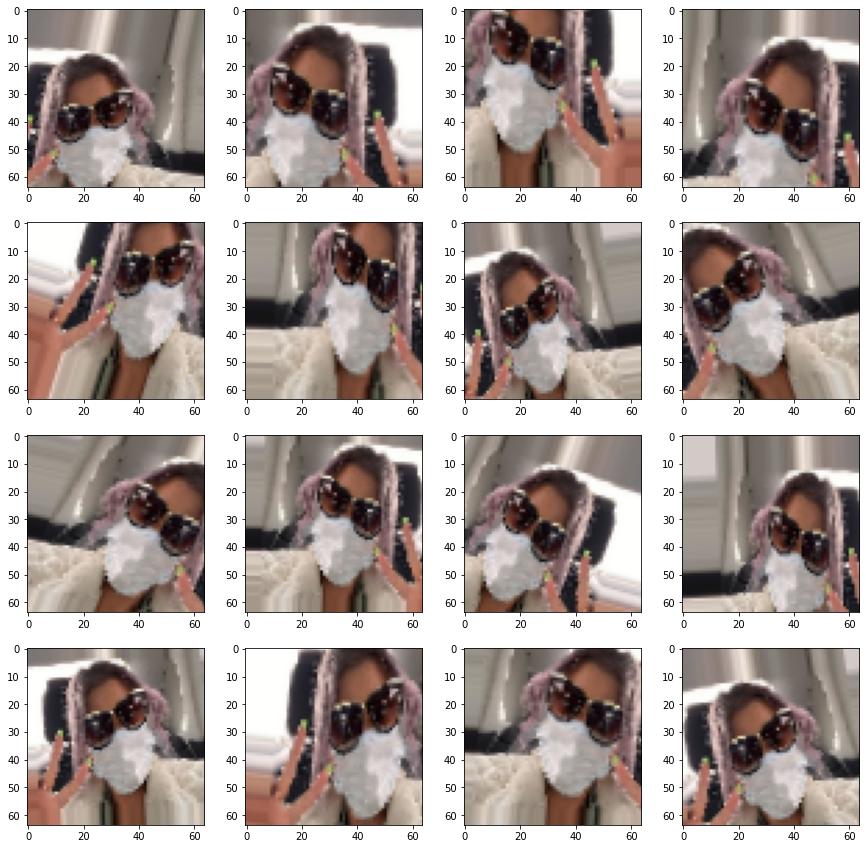

In [4]:
# testing the augmentation transformation
test_datagen = ImageDataGenerator(shear_range=0.2
                             ,zoom_range=0.2
                             ,validation_split=0.2
                             ,horizontal_flip=True
                             ,rotation_range=20
                             ,width_shift_range=0.2
                             ,height_shift_range=0.2
                             ,fill_mode='nearest')

it = test_datagen.flow(img, batch_size=1)
# generate samples and plot

plt.figure(figsize=(15,15))

for i in range(16):
    # define subplot
    plt.subplot(4,4,i+1) 
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()


## Preparing the dataset for data augmentation and tran validation split (80 : 20)

In [11]:
#Data augmentation or seems like data prep, here data preprocessing happens
path = "facemask2"
#rescale 1./255 to be RGB compliant
datagen = ImageDataGenerator(rescale=1./255
                             ,shear_range=0.2
                             ,zoom_range=0.2
                             ,validation_split=0.2
                             ,horizontal_flip=True
                             ,rotation_range=20
                             ,width_shift_range=0.2
                             ,height_shift_range=0.2
                             ,fill_mode='nearest')

# binary classentropy is used as there is only two class, mask or no mask

print("Training Set") #class_mode categorical if multiclass
training_set = datagen.flow_from_directory(path,
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),subset="training",
                                            batch_size=BATCH_SIZE,
                                            class_mode='binary')

print("Validation Set") #this is why shuffle set to false = https://stackoverflow.com/questions/53929819/generating-confusion-matrix-in-keras-for-multiclass-classification
validation_set = datagen.flow_from_directory(path,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),subset="validation",
                                           batch_size=BATCH_SIZE,shuffle=False,
                                           class_mode='binary')

Training Set
Found 805 images belonging to 2 classes.
Validation Set
Found 200 images belonging to 2 classes.


# Model fitting and training

In [45]:
#train
from IPython.display import display
from PIL import Image

checkpoint = ModelCheckpoint("4cnn.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

history = cf.fit(
        training_set,
        steps_per_epoch= STEPS_PER_EPOCH,
        epochs=EPOCHS,
        validation_data=validation_set,
        validation_steps=VALIDATION_STEPS,
        callbacks=[checkpoint,early])

Epoch 1/50
100/100 [==============================] - 39s 394ms/step - loss: 0.5551 - accuracy: 0.7104 - val_loss: 0.3798 - val_accuracy: 0.7377

Epoch 00001: val_accuracy improved from -inf to 0.73769, saving model to 4cnn.h5
Epoch 2/50
100/100 [==============================] - 40s 405ms/step - loss: 0.3761 - accuracy: 0.8346 - val_loss: 0.2367 - val_accuracy: 0.8711

Epoch 00002: val_accuracy improved from 0.73769 to 0.87109, saving model to 4cnn.h5
Epoch 3/50
100/100 [==============================] - 39s 390ms/step - loss: 0.3300 - accuracy: 0.8783 - val_loss: 0.0884 - val_accuracy: 0.8724

Epoch 00003: val_accuracy improved from 0.87109 to 0.87240, saving model to 4cnn.h5
Epoch 4/50
100/100 [==============================] - 38s 382ms/step - loss: 0.2989 - accuracy: 0.8859 - val_loss: 0.5005 - val_accuracy: 0.8795

Epoch 00004: val_accuracy improved from 0.87240 to 0.87953, saving model to 4cnn.h5
Epoch 5/50
100/100 [==============================] - 38s 377ms/step - loss: 0.2867

In [6]:
model = load_model('4cnn.h5')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 4, 4, 64)         

# Model evaluation

## Evaluating the model training and validation accuracy

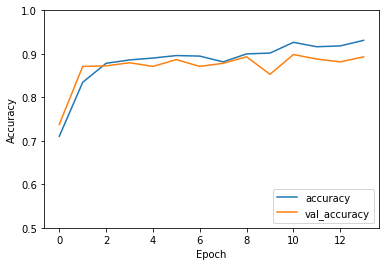

In [47]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cf.evaluate(validation_set, verbose=2)

## Evaluating the model training and validation loss

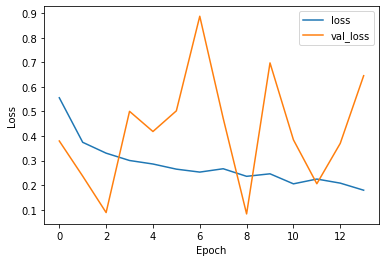

In [48]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

test_loss, test_acc = cf.evaluate(validation_set, verbose=2)

## Confusion Matrix and Classification Report

In [49]:
pred = cf.predict(validation_set)

In [50]:
y_true=validation_set.classes.tolist()

In [51]:
y_pred = []
for x in pred:
    if x[0]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [52]:
validation_set.class_indices

{'mask': 0, 'nomask': 1}

In [53]:
tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
print((tn, fp, fn, tp),"=> (tn, fp, fn, tp)")
print(classification_report(y_true,y_pred,target_names=['mask','nomask']))


(97, 3, 15, 85) => (tn, fp, fn, tp)
              precision    recall  f1-score   support

        mask       0.87      0.97      0.92       100
      nomask       0.97      0.85      0.90       100

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200



[[97  3]
 [15 85]]


Text(0.5, 15.0, 'Predicted label')

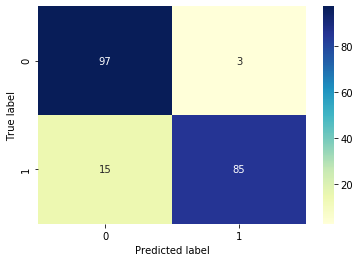

In [57]:
labels = [0, 1]
cm = confusion_matrix(y_true,y_pred,labels)
print(cm)
sns.heatmap(cm,cmap="YlGnBu", fmt='d', annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Real time detection with bounding box

In [12]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

#need load this detect face
face_cascade = cv2.CascadeClassifier('frontalface.xml')
if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    
    cv2.imshow("preview", frame)
    font = cv2.FONT_HERSHEY_SIMPLEX 
    rval, frame = vc.read()
    
    
    #face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        rect = cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        #pre-processing from opencv to pil then to classifier
        img = frame[y:y+h, x:x+w]
        img = cv2.resize(frame,(IMAGE_SIZE,IMAGE_SIZE))
        #convert from opencv->pil format
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img)
        test_image = img_to_array(pil_img)
        test_image = test_image/255.  # rescale
        test_image = expand_dims(test_image,axis=0)
        #make prediction
        result = model.predict_classes(test_image)
        class_dict = training_set.class_indices
        for k in class_dict:
            if result==class_dict[k]:
                cv2.putText(rect, k, (x, y-10), font, 0.9, (36,255,12), 2)
            
    #press to exit
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        print('exit')
        break

    
        
vc.release()
cv2.destroyWindow("preview")

exit
